Tài liệu này mang giấy phép Creative Commons Attribution (CC BY).
(c) Nguyễn Ngọc Sáng, Zhukovsky 12/2018.

[@SangVn](https://github.com/SangVn) [@VnCFD](https://vncfdgroup.wordpress.com/)

*Thực hành CFD với Python!*

# Bài 12. Sơ đồ Godunov, bài toán Riemann

### 1. Sơ đồ sai phân bảo toàn
Xét phương trình Burgers không nhớt dạng không phân kì:
$$\frac {\partial u}{\partial t} + u\frac{\partial u}{\partial x} = 0 \qquad (1)$$
Phương trình này có thể biểu diễn lại ở dạng phân kì:
$$\frac {\partial u}{\partial t} + \frac{\partial F}{\partial x} = 0; \ F=\frac{u^2}{2} \qquad (2)$$

Sử dụng phương pháp sai phân hữu hạn với sơ đồ upwind ta có hai sơ đồ sai phân tương ứng `dạng không bảo toàn và bảo toàn`:
$$\frac{u_i^{n+1}-u_i^n}{\Delta t} + u_i^n\frac{u_i^n - u_{i-1}^n}{\Delta x} = 0 \qquad (3)\\
\frac{u_i^{n+1}-u_i^n}{\Delta t} + \frac{F_i^n - F_{i-1}^n}{\Delta x} = 0 \qquad (4)$$
Xét thêm sơ đồ bậc hai MacCormack:
$$u_i^* = u_i^n - \frac{\Delta t}{\Delta x} [F_{i+1}^n - F_i^n]\\
u_i^{n+1} = \frac{1}{2}(u_i^n + u_i^*) - \frac{\Delta t}{2\Delta x} [F_i^* - F_{i-1}^*] \qquad (5)$$

Tìm nghiệm bài toán `lan truyền sóng xung kích` đã được giới thiệu ở [bài 5, phần 1](https://nbviewer.jupyter.org/github/SangVn/CFD_Notebook_P1/blob/master/Bai_5.ipynb):
$$u(x,0)=a,x≤x_0;u(x,0)=b,x>x_0;a>b$$
Nghiệm chính xác:
$$u(x,t)=a,x≤x_0+st;u(x,t)=b,x>x_0+st$$
với s là vận tốc dịch chuyển gián đoạn và bằng (a+b)/2. Nhờ biết được nghiệm chính xác, ta có thể dễ dàng kiểm tra kết quả tính toán.

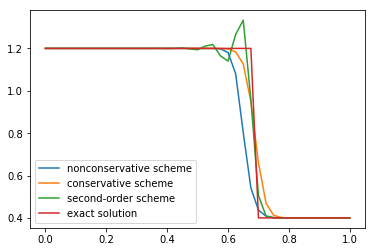

In [2]:
import numpy as np
import matplotlib.pyplot as plt

#chia lưới trên đoạn [0, 1]
nx = 41
x, dx = np.linspace(0, 1, nx, retstep=True)

#bước thời gian
r = 0.4 #điều kiện ổn định: u_max dt/dx <= 1
dt = r*dx

#điều kiện ban đầu
uL = 1.2
uR = 0.4

u0 = np.zeros(nx)
i = int(0.5/dx)
u0[:i] = uL
u0[i:] = uR

#sơ đồ sai phân 3
def nonconservative_scheme(nt):
    u = u0.copy()
    un = np.zeros(nx)
    for n in range(nt):
        un = u.copy()
        u[1:] = un[1:] - dt/dx*un[1:]*(un[1:] - un[:-1])
    return u

#sơ đồ sai phân 4 (F=u^2/2)
def conservative_scheme(nt):
    u = u0.copy()
    un = np.zeros(nx)
    for n in range(nt):
        un = u.copy()
        u[1:] = un[1:] - dt/(2*dx)*(un[1:]**2 - un[:-1]**2)
    return u

#sơ đồ bậc hai MacCormack
def second_order_scheme(nt):
    u = u0.copy()
    u1 = u0.copy()
    un = np.zeros(nx)
    for n in range(nt):
        un = u.copy()
        u1[1:-1] = un[1:-1] - dt/(2*dx)*(un[2:]**2 - un[1:-1]**2)
        u[1:-1] = (un[1:-1] + u1[1:-1])/2 - dt/(4*dx)*(u1[1:-1]**2 - u1[:-2]**2)
    return u    

#so sánh nghiệm tìm được
nt = 25
u_1 = nonconservative_scheme(nt)
u_2 = conservative_scheme(nt)
u_3 = second_order_scheme(nt)
#nghiệm chính xác: vận tốc lan truyền sóng xung kích s=(uL+uR)/2. = 0.8
u_exact = np.zeros(nx)
i = int((0.5 + 0.8*nt*dt)/dx)
u_exact[:i] = uL
u_exact[i:] = uR

plt.plot(x, u_1, x, u_2, x, u_3, x, u_exact)
plt.legend(['nonconservative scheme', 'conservative scheme', 'second-order scheme', 'exact solution'])
plt.show()

Ta thấy, với sơ đồ không bảo toàn, `sóng xung kích chuyển động sai vận tốc`, khác với trường hợp sơ đồ bảo toàn. Sử dụng sơ đồ bảo toàn là cần thiết. Ta cũng thấy rằng sơ đồ bậc hai cho gián đoạn có độ dốc lớn nhưng lại làm xuất hiện dao động.

Như đã nói ở bài trước, ngoài sử dụng phương pháp sai phân hữu hạn biến đổi phương trình vi phân ở dạng phân kì để thu được sơ đồ sai phân bảo toàn, ta có thể sử dụng phương pháp `thể tích hữu hạn`.

### 2. Phương pháp Godunov

Sử dụng phương pháp `thể tích hữu hạn` ta thu được sơ đồ sai phân:
$$\frac{du}{dt} + \frac{F_{i+1/2} - F_{i-1/2}}{\Delta x} = 0$$
với xấp xỉ thời gian upwind bậc 1 ta có:
$$\frac{u_i^{n+1} - u_i^n}{\Delta t} + \frac{F_{i+1/2} - F_{i-1/2}}{\Delta x} = 0$$
ở đây $u_i$ là giá trị trung bình trên đoạn [i-1/2, i+1/2]: 
$$u_i^n = \frac{1}{\Delta x}\int_{i-1/2}^{i+1/2} u(x, t_n) dx$$

Trong phương pháp Godunov hàm dòng F xác định như sau:
$$F_{i-1/2}^* = F(u_{i-1/2}^*(u_{i-1/2}^L, u_{i-1/2}^R)); \quad F_{i+1/2}^* = F(u_{i+1/2}^*(u_{i+1/2}^L, u_{i+1/2}^R))$$

với $u^*$ là nghiệm của `bài toán Riemann - phân rã gián đoạn` trên bề mặt thể tích hữu hạn: cho giá trị u tại hai bên trái phải của bề mặt là uL, uR, tìm nghiệm $u^*(u_L, u_R)$ ở trên bề mặt. Godunov lấy uL, uR chính là giá trị trung bình u ở hai thể tích hữu hạn hai bên bề mặt đang xét $u_{i+1/2}^*(u_i, u_{i+1})$.


**Bài toán Riemann**

Chúng ta đã xem xét qua bài toán Riemann ở phần một, bây giờ ta sẽ nghiên cứu cụ thể hơn. Giả thiết bài toán:
$$u_t + F(u)_x = 0 \qquad (6)\\
u(t=0)=u_0 = 
\begin{cases}
u_L; \quad x<0 \\ 
u_R; \quad x>0
\end{cases}
$$
<img src='img/Bai_12.png' width=400>

Để giải bài toán này ta cần biết về `đường đặc trưng và sóng`.

**Đường đặc trưng**

Xét phương trình $u_t + au_x = 0 \qquad (7)$. 

*Đường đặc trưng được định nghĩa là đường trong không gian mà dọc theo nó phương trình đạo hàm riêng (PDE) trở thành phương trình vi phân thường (ODE).*

Xem $x=x(t)$, ta có:
$$\frac{du}{dt} = \frac{\partial u}{\partial t} + \frac{\partial u}{\partial x} \frac{dx}{dt}$$
Nếu $x'=a$ ta có:
$$\frac{du}{dt} = \frac{\partial u}{\partial t} + a\frac{\partial u}{\partial x} = 0$$
Nghĩa là $u$ là hằng số dọc theo đường $\frac{dx}{dt} = a$. Ở đây $a$ được gọi là vận tốc đặc trưng và bằng độ dốc của đường $x(t)$. Trong trường hợp tổng quát $a=a(x,t)$.

Giả thiết tại thời điểm ban đầu $x(t=0)=x_0$, ta có nghiệm phương trình $x'=a$: $x=x_0+at$. Dọc theo đường đặc trưng u là hằng số nên ta có:
$$u(x,t) = u(x(0),0)=u_0(x_0)=u_0(x-at)$$
Nghiệm u chính là $u_0$ ban đầu được dịch chuyển với vận tốc $a$ sang trái hoặc sang phải tùy theo dấu của $a$. Quá trình này ta gọi là `dịch chuyển sóng`.

<img src='img/Bai_12_2.png' width=600>

Quay lại với bài toán Riemann, phương trình (6) có thể viết lại ở dạng: 
$$u_t + Au_x = 0$$ 
với $A=\frac{\partial F}{\partial u}$ gọi là ma trận Jacobian. `Giá trị riêng` của ma trận A chính là vận tốc đường đặc trưng hay vận tốc dịch chuyển sóng. Đối với phương trình trình (7): $A=|a|, \lambda = a$. Với a là hằng số, sóng dịch chuyển với vận tốc không đổi nên hình dạng không đổi. Đối với phương trình (2): $A=|u|, \lambda=u$, sóng dịch chuyển với vận tốc phụ thuộc thời gian và không gian điều này có thể dẫn đến sự giao cắt, phân tách đường đặc trưng làm xuất hiện sóng va đập và sóng giãn như đã giới thiệu ở phần 1.

Trong trường hợp bài toán Riemann cho phương trình (2), ta thấy sóng ở hai bên trái phải chuyển động với hai vận tốc khác nhau uL và uR.

Tại $x_{i+i/2}$ 'cấu hình' đường đặc trưng có nhiều dạng phụ thuộc mối liên hệ uL, uR, ví dụ:

<img src='img/Bai_12_3.png'>

Hình 1 ngoài cùng bên trái: $u_L<0<u_R$, hình 2:$u_R>u_L>0$, hình 3: $u_L<u_R<0$, hình 4 ngoài cùng bên phải: $u_L>0>u_R, (u_L+u_R)/2<0$. **Chú ý:$u=dx/dt$.**  

Căn cứ vào vị trí $x_{i+1/2}$ thuộc vùng 1, 2 hay 3 và mối liên hệ uL, uR - sóng nào dịch chuyển nhanh hơn, về phía nào để ta xác định $u^*$. Ví dụ như trên hình, hình 1 - $x_{i+1/2}$ nằm giữa (1) và (2) - lấy bằng 0, hình 2 - nằm trong (1) - lấy uL, hình 3 - nằm trong (2) - lấy uR, hình 4 - nằm trong vùng giao thoa, ở đây ta lấy sóng nào chuyển động nhanh hơn - ảnh hưởng mạnh hơn, chạy tới ${i+1/2}$ nhanh hơn. Tổng hợp tất cả các trường hợp ta có:

Nếu $u_L > u_R$ - sóng xung kích:
$$
u* =
\begin{cases}
u_L; \ if\quad \frac{u_L+u_R}{2}>0 \\ 
u_R; \ in\ other\ case
\end{cases}
$$
Nếu $u_L \leq u_R$ - sóng giãn:

$$
u* =
\begin{cases}
u_L; \ if\quad u_L>0 \\ 
u_R; \ if\quad u_R<0 \\
0; \quad if\quad u_L \leq 0 \leq u_R
\end{cases}
$$

In [2]:
#tìm nghiệm bài toán Riemann
def decay_godunov(uL, uR):
    ustar = 0
    if uL > uR:
        if (uL + uR)/2. > 0: ustar = uL
        else: ustar = uR
    else:
        if uL > 0: ustar = uL
        elif uR < 0: ustar = uR
        else: ustar = 0
    return ustar

#tính hàm dòng F(u*)
def flux(u):
    return u**2/2.

#sơ đồ Godunov
def godunov_method(nt):
    u = u0.copy()
    un = np.zeros(nx)
    for n in range(nt):
        un = u.copy()
        for i in range(1, nx-1):
            u_im05 = decay_godunov(un[i-1], un[i]) #u_{i-1/2}
            u_ip05 = decay_godunov(un[i], un[i+1]) #u_{i+1/2}
            u[i] = un[i] - dt/dx*(flux(u_ip05) - flux(u_im05))
    return u

#có thể viết lại code như sau
def godunov_scheme(nt):
    u = u0.copy()
    un = np.zeros(nx)
    for n in range(nt):
        un = u.copy()
        ustar = np.array([decay_godunov(ul, ur) for ul, ur in zip(un[:-1], un[1:])])
        u[1:-1] = un[1:-1] - dt/dx*(flux(ustar[1:]) - flux(ustar[:-1]))
            
    return u

%time u_g = godunov_method(nt)
%time u_g_2 = godunov_scheme(nt)

CPU times: user 3.86 ms, sys: 0 ns, total: 3.86 ms
Wall time: 2.73 ms
CPU times: user 1.42 ms, sys: 186 µs, total: 1.61 ms
Wall time: 1.15 ms


So sánh thời gian chạy hai đoạn code khác nhau, rõ ràng sử dụng tính toán mảng numpy nhanh hơn nhiều.

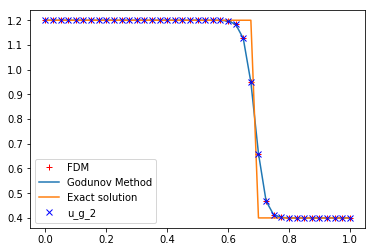

In [3]:
#lưu giá trị u_g vào file để so sánh ở bài 13
np.savetxt('data/burgers_godunov_test1.dat', u_g)

plt.plot(x, u_2, 'r+')
plt.plot(x, u_g, x, u_exact)
plt.plot(x, u_g_2, 'bx')

plt.legend(['FDM', 'Godunov Method', 'Exact solution', 'u_g_2'])
plt.show()

Với bài toán chúng ta đang xét có uL = 1.2 > uR = 0.4, sơ đồ Godunov suy biến về dạng sơ đồ sai phân bảo toàn (4). Nghiệm thu được từ hai sơ đồ là như nhau.

In [4]:
#xét bài toán sóng giãn
uL = -0.4 # <0 - dịch chuyển sang trái
uR = 1.2  # >0 - dịch chuyển sang phải 

u0 = np.zeros(nx)
i = int(0.5/dx)
u0[:i] = uL
u0[i:] = uR

u_4 = nonconservative_scheme(nt)
u_5 = conservative_scheme(nt)
u_6 = godunov_scheme(nt)

#lưu giá trị u_g vào file để so sánh ở bài 13
np.savetxt('data/burgers_godunov_test2.dat', u_6)

u_exact = u0.copy()
t = nt*dt
i = int((0.5 + uL*t)/dx)
j = int((0.5 + uR*t)/dx)
for k in range(i+1, j): u_exact[k] = (x[k]-0.5)/t

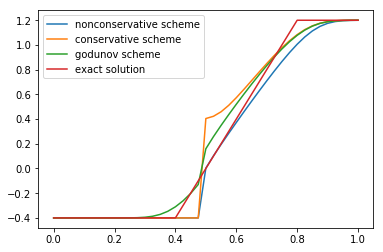

In [5]:
plt.plot(x, u_4, x, u_5, x, u_6, x, u_exact)
plt.legend(['nonconservative scheme','conservative scheme', 'godunov scheme', 'exact solution'])
plt.show()

Kết quả ba phương pháp là hoàn toàn khác biệt. Phương pháp Godunov cho kết quả chính xác hơn.

Sơ đồ Godunov ta đang dùng là sơ đồ bậc 1, nó có tính chất tiêu tán, tính nhớt như đã phân tích ở phần 1.

### [Bài 13. Định lý Godunov, sơ đồ TVD, sơ đồ MUSCL](Bai_13.ipynb)
